In [378]:
import csv
import math as m
from random import uniform as unif
import networkx as nx
import pandas as pd
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [379]:
expid = "./exp2_run0"

In [380]:
if not os.path.exists(expid):
    os.makedirs(expid)

# Problem instance

## Geographic data

In [381]:
from pkg.read_problem import read_problem, extract_problem

In [382]:
xy_customers, xy_icps, xy_crcs, xy_pc, q = read_problem('./datasets/original')

In [383]:
xy_icps = xy_icps + [[unif(20,100),unif(20,70)] for i in range(5)]
xy_crcs = xy_crcs + [[unif(20,100),unif(20,70)] for i in range(1)]

In [384]:
I,J,C,B,K,V,W,DjUc,Dcj,Dc,FCV,FCT,FCR,U = extract_problem(xy_customers, xy_icps, xy_crcs, xy_pc, q)

## Capacity constraints

In [385]:
Q_icp = [200 for j in range(J)]
Q_crc = [800 for c in range(C)]
V = [Q_icp,Q_crc]

## Adapting costs

In [386]:
# two-level cost
FCRD = []
for c in range(C):
    FCRD.append(FCR[c] + Dc[c])

f = FCT+FCRD
c = [[[W[i][j1] + Dcj[j1][j2] for j2 in range(C)] for j1 in range(J)] for i in range(I)]

# Plot Problem

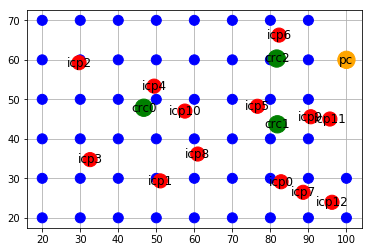

In [387]:
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
G, pos, labels, colors, size = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs, xy_pc)

lrp_draw_and_save(G, pos, labels, colors, size, expid+"/problem.png")

In [388]:
%%file "./pkg/draw_solution_II.py"

def draw_solution_II(I,J,C,
                    N_crc, N_icp,
                    Y1,Y2, routes, expid,
                    G, pos, labels, colors, size, path=None):
    
    from IPython.display import display, HTML
    import pandas as pd
    from pkg.draw_solution_II import draw_solution_II
    from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
    
    H1 = [j for j,vj in enumerate(N_icp) if vj > 0.5]
    
    ###############################
    # DataFrames
    display(pd.DataFrame(N_crc).transpose())
    display(pd.DataFrame(N_icp).transpose())
    display(pd.DataFrame(routes).transpose())   
    ###############################
    # Network
    G2 = G.copy()
    colors = colors[:];size = size[:]; labels = labels.copy()
    # ICP-Cus
    for j,vj in enumerate(Y1):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)
    # ICP
    for j,vj in enumerate(N_icp):
        if vj < 0.5:
            colors[I+j] = "grey"
            labels[I+j] = ""
            size[I+j] = 50

    # ICP-CRC
    for j,vj in enumerate(Y2):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+J+i,I+H1[j])
    # CRC
    for j,vj in enumerate(N_crc):
        if vj < 0.5:
            colors[I+J+j] = "grey"
            labels[I+J+j] = ""
            size[I+J+j] = 50

    # Routes
    for r,vr in enumerate(routes):
        for c, vc in enumerate(vr):
            G2.add_edge(I+vc[0],I+vc[1])

    lrp_draw_and_save(G2, pos, labels, colors, size, path)
    
    return G2

Overwriting ./pkg/draw_solution_II.py


# Define Functions

## cflp_first_tsp_second

In [389]:
%%file "./pkg/cflp_first_tsp_second.py"

def cflp_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W1,W2,W3,F1,F2,
                U,Q_icp,Q_crc,
                plots=True, expid=""):
    
    from pkg.cflp_cplex import cflp_cplex
    from pkg.tsp_cplex import tsp_cplex
    from pkg.read_problem import read_problem, extract_problem
    from pkg.draw_solution_II import draw_solution_II
    from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
    import numpy as np
    import pandas as pd
    from IPython.display import display, HTML

    #######################################################################
    # Solve first problem
    prob1, Y1, N_icp = cflp_cplex(I,J,
                W1,F1,U,Q_icp,
                relaxation=False)
    
    #######################################################################
    # Prepare 2nd problem
    H1 = [j for j,vj in enumerate(N_icp) if vj > 0.5]
    
    c2=[];    u2=[];
    for j in H1:
        c2.append(W2[j])
        sqi = 0
        for i in range(I):
            sqi += U[i]*Y1[i][j]
        u2.append(sqi)
    #######################################################################        
    # Solve Second problem
    prob2, Y2, N_crc = cflp_cplex(len(u2),C,
            c2,F2,u2,Q_crc,
            relaxation=False)    
    #######################################################################
    # Preparing TSP
    H2 = [j for j,vj in enumerate(N_crc) if vj > 0.5]
    tY2 = np.transpose(Y2)
    W3 = np.asarray(W3)
    
    #/!\ Use H1 as a labeling array

    S_tsp = [] #set of ICP in each TSP
    for c,vc in enumerate(H2):
        S_tsp.append([H1[j] for j,vj in enumerate(tY2[c]) if vj > 0.5]+[J+vc])
    
    w_tsp = []
    for submat in S_tsp:
        w_tsp.append(W3[submat,:][:,submat])
    #######################################################################
    # Solving TSP
    routes = []
    for c,vc in enumerate(w_tsp):
        prob, X = tsp_cplex(len(vc),vc, relaxation=False)
        # Extract routes
        path = []
        for j,xj in enumerate(X):
            for i,xij in enumerate(xj):
                if xij == 1:
                    path.append((S_tsp[c][i],S_tsp[c][j]))
        routes.append(path)
    #######################################################################
    # Draw solution
    if(plots):
        draw_solution_II(I,J,C,N_crc, N_icp,
                    Y1,Y2, routes, expid,
                    G, pos, labels, colors, size)
    
    return Y1, Y2, N_icp, N_crc, routes

Overwriting ./pkg/cflp_first_tsp_second.py


In [390]:
from pkg.cflp_first_tsp_second import cflp_first_tsp_second

,0,1,2
0,1.0,1.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


,0,1
0,"(13, 1)","(12, 0)"
1,"(3, 2)","(14, 5)"
2,"(1, 3)","(5, 6)"
3,"(2, 4)","(6, 12)"
4,"(4, 13)","(0, 14)"


Wall time: 763 ms


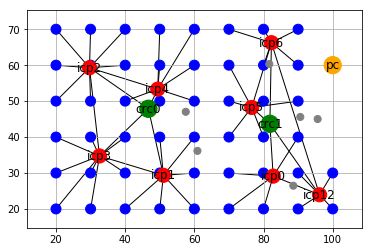

In [391]:
%%time
Y1, Y2, N_icp, N_crc, routes = cflp_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W,Dcj,DjUc,FCT,FCRD,
                U,Q_icp,Q_crc,
                expid=expid)

In [392]:
from pkg.objective_III import objective_III
objective_III(Y1,routes,N_icp, N_crc,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

(2576.2606677432714,
 508.12249649077626,
 189.06934172658094,
 800.0,
 1079.0688295259142)

## pmd_first_tsp_second

In [393]:
%%file "./pkg/pmd_first_tsp_second.py"

def pmd_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W1,W2,W3,F1,F2,
                U,Q_icp,Q_crc,
                plots=True, expid=""):
    
    from pkg.cflp_cplex import cflp_cplex
    from pkg.pm_flp_cplex import pm_flp_cplex
    from pkg.tsp_cplex import tsp_cplex
    from pkg.read_problem import read_problem, extract_problem
    from pkg.draw_solution_II import draw_solution_II
    from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
    import numpy as np
    import pandas as pd
    from IPython.display import display, HTML

    #######################################################################
    # Solve first problem
    prob1, Y1, N_icp = pm_flp_cplex(I,J,
                W1,8,
                relaxation=False)
    
    #######################################################################
    # Prepare 2nd problem
    H1 = [j for j,vj in enumerate(N_icp) if vj > 0.5]
    
    c2=[];    u2=[];
    for j in H1:
        c2.append(W2[j])
        sqi = 0
        for i in range(I):
            sqi += U[i]*Y1[i][j]
        u2.append(sqi)
        
    print(u2)
    #######################################################################        
    # Solve Second problem
    prob2, Y2, N_crc = pm_flp_cplex(len(u2),C,
            c2,2,
            relaxation=False)    
    #######################################################################
    # Preparing TSP
    H2 = [j for j,vj in enumerate(N_crc) if vj > 0.5]
    tY2 = np.transpose(Y2)
    W3 = np.asarray(W3)
    
    #/!\ Use H1 as a labeling array

    S_tsp = [] #set of ICP in each TSP
    for c,vc in enumerate(H2):
        S_tsp.append([H1[j] for j,vj in enumerate(tY2[c]) if vj > 0.5]+[J+vc])
    
    w_tsp = []
    for submat in S_tsp:
        w_tsp.append(W3[submat,:][:,submat])
    #######################################################################
    # Solving TSP
    routes = []
    for c,vc in enumerate(w_tsp):
        prob, X = tsp_cplex(len(vc),vc, relaxation=False)
        # Extract routes
        path = []
        for j,xj in enumerate(X):
            for i,xij in enumerate(xj):
                if xij == 1:
                    path.append((S_tsp[c][i],S_tsp[c][j]))
        routes.append(path)
    #######################################################################
    # Draw solution
    if(plots):
         draw_solution_II(I,J,C,N_crc, N_icp,
                    Y1,Y2, routes, expid,
                    G, pos, labels, colors, size)
            
    return Y1, Y2 , N_icp, N_crc, routes

Overwriting ./pkg/pmd_first_tsp_second.py


In [394]:
from pkg.pmd_first_tsp_second import pmd_first_tsp_second

[210.0, 175.0, 200.0, 200.0, 175.0, 175.0, 175.0, 130.0]


,0,1,2
0,1.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,1.0


,0,1
0,"(13, 1)","(12, 0)"
1,"(3, 2)","(14, 5)"
2,"(1, 3)","(5, 6)"
3,"(2, 4)","(6, 12)"
4,"(4, 13)","(0, 14)"


Wall time: 255 ms


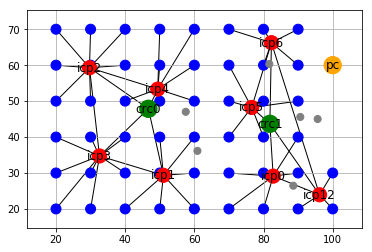

In [395]:
%%time
Y12, Y22, N_icp2, N_crc2, routes2 = pmd_first_tsp_second(G,pos, labels, colors, size,
                I,J,C,
                W,Dcj,DjUc,FCT,FCRD,
                U,Q_icp,Q_crc,
                expid=expid)

In [396]:
from pkg.objective_III import objective_III
objective_III(Y12,routes2,N_icp2, N_crc2,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

(2574.8363423188098,
 506.69817106631467,
 189.06934172658094,
 800.0,
 1079.0688295259142)

## Capacity problem

In [397]:
%%file "./pkg/capacity_vector.py"

import numpy as np

def capacity_vector(Y,U,J,Q):
    cluster_q = np.zeros(J)
    violated = []
    for i,vi in enumerate(Y):
        for j,vj in enumerate(vi):
            cluster_q[j] += U[i]*Y[i][j]
    
    for j,vj in enumerate(cluster_q):
        if cluster_q[j] > Q[j]:
            violated.append(j)
            
    return cluster_q, violated

Overwriting ./pkg/capacity_vector.py


In [398]:
from pkg.capacity_vector import capacity_vector

In [399]:
capacity_vector(Y1,U,J,Q_icp)

(array([ 160.,  175.,  200.,  200.,  175.,  175.,  175.,    0.,    0.,
           0.,    0.,    0.,  180.]), [])

In [400]:
capacity_vector(Y12,U,J,Q_icp)

(array([ 210.,  175.,  200.,  200.,  175.,  175.,  175.,    0.,    0.,
           0.,    0.,    0.,  130.]), [0])

In [401]:
%%file "./pkg/capacity_balancing.py"

import numpy as np
from pkg.capacity_vector import capacity_vector

def capacity_balancing(Y,W,U,J,Q,N_icp):
    l = len(capacity_vector(Y,U,J,Q)[1])
    max_loop = 10;

    # capacity balancing
    Ycp = np.copy(Y)
    Wcp = np.copy(W)
    while l != 0 or max_loop == 0:
        max_loop +=-1
        j = capacity_vector(Ycp,U,J,Q)[1][0]
        i = np.argmax(np.multiply(Ycp,W)[:,j])
        # Find condidate and update
        Ycp[i][j] = 0
        Wcp[i][j] = 100
        stop = False
        while not stop:
            candidate = np.argmin(Wcp[i])
            if N_icp[candidate] > 0.5 and candidate != j:
                stop = True
            else:
                Wcp[i][candidate] = 200

        print(i,j,candidate)

        Ycp[i][candidate] = 1
        Wcp[i][candidate] = 100

        l = len(capacity_vector(Ycp,U,J,Q)[1])
        
    return Ycp

Overwriting ./pkg/capacity_balancing.py


In [402]:
capacity_vector(Y12,U,J,Q_icp)

(array([ 210.,  175.,  200.,  200.,  175.,  175.,  175.,    0.,    0.,
           0.,    0.,    0.,  130.]), [0])

In [403]:
from pkg.capacity_balancing import capacity_balancing

In [404]:
%%time
Y12_capa = capacity_balancing(Y12,W,U,J,Q_icp,N_icp2)
print(capacity_vector(Y12_capa,U,J,Q_icp))

30 0 1
(array([ 185.,  200.,  200.,  200.,  175.,  175.,  175.,    0.,    0.,
          0.,    0.,    0.,  130.]), [])
Wall time: 2 ms


## Swap problem

In [405]:
def swap_list(Y,W,DjUc,N_icp):
    cluster_len = np.max(np.multiply(Y,W),axis=0)
    swaps = []
    for j,l in enumerate(cluster_len):
        for j_bis,n in enumerate(DjUc[j]):
            if n<l and j != j_bis and j_bis < J and N_icp[j_bis] == 0:
                swaps.append((j,j_bis))
    return swaps

In [406]:
swap_list(Y1,W,DjUc,N_icp)

[(0, 7), (1, 8), (4, 10), (12, 7)]

In [407]:
def swap_list_byRoute(Y,W,DjUc,N_icp):
    cluster_len = np.max(np.multiply(Y,W),axis=0)
    swaps = []
    for iroute,route in enumerate(routes):
        for iarc,arc in enumerate(route): #chose on element
            if arc[0] < len(cluster_len): # do not select CRC
                for j_bis,n in enumerate(DjUc[arc[0]]): # look at other
                    if j_bis < len(cluster_len):
                        if n<cluster_len[arc[0]] and cluster_len[j_bis] == 0 and arc[0] != j_bis:
                            coarc = [[iroute, ico] for ico,co in enumerate(route) if co[1] == arc[0]]
                            swaps.append(([iroute,iarc],coarc[0],arc[0],j_bis))         
    return swaps

In [408]:
swap_list = swap_list_byRoute(Y1,W,DjUc,N_icp)
swap_list

[([0, 2], [0, 0], 1, 8),
 ([0, 4], [0, 3], 4, 10),
 ([1, 0], [1, 3], 12, 7),
 ([1, 4], [1, 0], 0, 7)]

In [409]:
print(routes[0][1])
print(routes[0][2])

(3, 2)
(1, 3)


In [410]:
routes

[[(13, 1), (3, 2), (1, 3), (2, 4), (4, 13)],
 [(12, 0), (14, 5), (5, 6), (6, 12), (0, 14)]]

In [411]:
swap = swap_list[0]

In [412]:
def swap_arcs(swap, routes, N_icp):
    routes_swap = np.copy(routes)
    N_icp_swap = N_icp[:]
    remove = swap[2]
    introduce = swap[3]
    
    print("swap: %s %s" % (remove,introduce))

    arc1 = routes_swap[swap[0][0]][swap[0][1]]
    arc2 = routes_swap[swap[1][0]][swap[1][1]]

    if arc1[0] == remove:
        arc1 = (introduce, arc1[1])
    else:
        arc1 = (arc1[0], introduce)

    if arc2[0] == remove:
        arc2 = (introduce, arc2[1])
    else:
        arc2 = (arc2[0], introduce)

    routes_swap[swap[0][0]][swap[0][1]] = arc1
    routes_swap[swap[1][0]][swap[1][1]] = arc2
    N_icp_swap[remove] = 0
    N_icp_swap[introduce] = 1

    return routes_swap, N_icp_swap

In [413]:
routes_swap, N_icp_swap = swap_arcs(swap, routes, N_icp)

swap: 1 8


In [414]:
routes_swap

array([[[13,  8],
        [ 3,  2],
        [ 8,  3],
        [ 2,  4],
        [ 4, 13]],

       [[12,  0],
        [14,  5],
        [ 5,  6],
        [ 6, 12],
        [ 0, 14]]])

In [415]:
from pkg.objective_III import objective_III
objective_III(Y1,routes_swap,N_icp_swap, N_crc,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

(2584.7291661448603,
 508.12249649077626,
 197.53784012816996,
 800.0,
 1079.0688295259142)

,0,1,2
0,1.0,1.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


,0,1
0,"[13, 8]","[12, 0]"
1,"[3, 2]","[14, 5]"
2,"[8, 3]","[5, 6]"
3,"[2, 4]","[6, 12]"
4,"[4, 13]","[0, 14]"


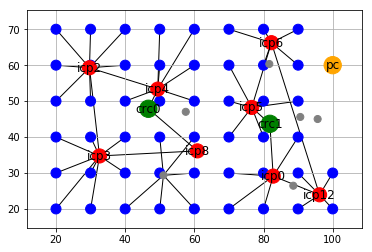

In [416]:
from pkg.draw_solution_II import draw_solution_II
g3 = draw_solution_II(I,J,C,N_crc, N_icp_swap,
            Y1, np.zeros((3,8)), routes_swap.tolist(), expid,
            G, pos, labels, colors, size)

In [417]:
# swapp customers
def new_assignement(W,N_icp_swap):
    H1 = [j for j,vj in enumerate(N_icp_swap) if vj > 0.5]
    asso = np.argmin(np.transpose(W)[H1],axis=0)
    new_Y = np.zeros((I,J))
    for a,va in enumerate(asso):
        new_Y[a][H1[va]] = 1
    return new_Y

In [418]:
pd.DataFrame(np.transpose(W)[H1])

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,32.436802,31.066801,32.835135,37.298071,43.636523,51.158050,23.042268,21.070028,23.599706,29.494849,...,42.153838,49.899360,40.046799,38.945425,40.370114,44.076594,49.555485,56.291617,49.825155,48.944316
1,40.455170,30.838625,21.573614,13.409728,9.706740,14.443711,39.281303,29.281749,19.282655,9.285516,...,50.325151,51.449206,71.982087,67.050882,63.326304,61.029671,60.324297,61.265168,80.547010,76.172310
2,19.378442,13.443363,13.635395,19.776855,28.219213,37.436934,14.964090,5.396666,5.858669,15.476563,...,53.728242,59.092504,59.281734,57.615310,57.660420,59.413164,62.730567,67.381926,69.012492,67.586419
3,44.464503,37.553855,32.303127,29.608985,30.164416,33.809644,38.583572,30.362674,23.560390,19.705126,...,31.296837,34.823728,52.519444,46.813374,42.716414,40.717220,41.122889,43.866753,60.579634,55.705404
4,63.244966,59.456923,57.186762,56.617362,57.799011,60.629413,54.480508,50.033246,47.313061,46.623231,...,12.244415,22.025569,31.262209,22.639030,15.739304,13.525003,17.836079,25.560237,36.681408,29.677023
5,77.580835,72.066539,67.589837,64.367585,62.593818,62.392195,69.808209,63.623785,58.504581,54.750215,...,6.662282,4.380183,46.899744,37.072712,27.371262,17.999611,9.939115,8.578228,49.537723,40.358221
6,68.913451,68.701264,69.933280,72.535948,76.369259,81.259238,58.964936,58.716809,60.153667,63.160618,...,34.627499,44.383147,6.607851,3.803117,13.611161,23.581003,33.568791,43.562182,13.094415,11.927435
7,75.123278,72.330643,70.851513,70.768298,72.085831,74.730061,65.809518,62.602777,60.887788,60.790935,...,17.907589,26.625116,25.597020,15.602002,5.624722,4.455617,14.424547,24.418898,27.250564,18.188135


,0,1,2
0,1.0,1.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


,0,1
0,"[13, 8]","[12, 0]"
1,"[3, 2]","[14, 5]"
2,"[8, 3]","[5, 6]"
3,"[2, 4]","[6, 12]"
4,"[4, 13]","[0, 14]"


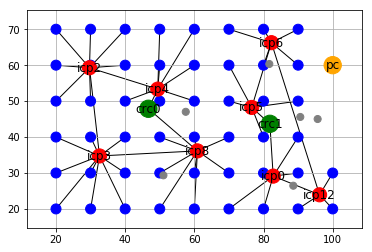

In [419]:
from pkg.draw_solution_II import draw_solution_II

new_Y = new_assignement(W,N_icp_swap)
g3 = draw_solution_II(I,J,C,N_crc, N_icp_swap,
            new_Y, np.zeros((3,8)), routes_swap.tolist(), expid,
            G, pos, labels, colors, size)

In [420]:
from pkg.objective_III import objective_III
objective_III(new_Y,routes_swap,N_icp_swap, N_crc,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

(2595.5420779979977,
 518.93540834391376,
 197.53784012816996,
 800.0,
 1079.0688295259142)

## final Algorithm

In [421]:
best_solution = []

30 0 1


,0,1,2
0,1.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,1.0


,0,1
0,"(13, 1)","(12, 0)"
1,"(3, 2)","(14, 5)"
2,"(1, 3)","(5, 6)"
3,"(2, 4)","(6, 12)"
4,"(4, 13)","(0, 14)"


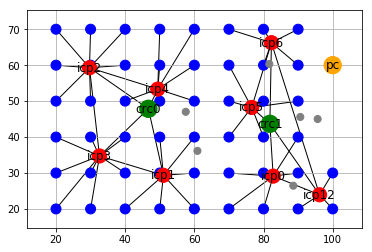

In [422]:
# %%file "./pkg/pmd_first_tsp_second.py"

# def pmd_first_tsp_second(G,pos, labels, colors, size,
#                 I,J,C,
#                 W1,W2,W3,F1,F2,
#                 U,Q_icp,Q_crc,
#                 plots=True, expid=""):
    
from pkg.cflp_cplex import cflp_cplex
from pkg.pm_flp_cplex import pm_flp_cplex
from pkg.tsp_cplex import tsp_cplex
from pkg.read_problem import read_problem, extract_problem
from pkg.draw_solution_II import draw_solution_II
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
import numpy as np
import pandas as pd
from IPython.display import display, HTML

W1,W2,W3,F1,F2 = W,Dcj,DjUc,FCT,FCRD
plots = True

#######################################################################
# 1 Solve first problem
prob1, Y1, N_icp = pm_flp_cplex(I,J,
            W1,8,
            relaxation=False)

#######################################################################
# 2 Prepare 2nd problem
H1 = [j for j,vj in enumerate(N_icp) if vj > 0.5]

# 12 Prepare 2nd problem
Y1_capa = capacity_balancing(Y12,W,U,J,Q_icp,N_icp2)

c2=[];    u2=[];
for j in H1:
    c2.append(W2[j])
    sqi = 0
    for i in range(I):
        sqi += U[i]*Y1[i][j]
    u2.append(sqi)

#######################################################################        
# 3. Solve Second problem
prob2, Y2, N_crc = pm_flp_cplex(len(u2),C,
        c2,2,
        relaxation=False)    

#######################################################################
# Preparing TSP
H2 = [j for j,vj in enumerate(N_crc) if vj > 0.5]
tY2 = np.transpose(Y2)
W3 = np.asarray(W3)

#/!\ Use H1 as a labeling array

S_tsp = [] #set of ICP in each TSP
for c,vc in enumerate(H2):
    S_tsp.append([H1[j] for j,vj in enumerate(tY2[c]) if vj > 0.5]+[J+vc])

w_tsp = []
for submat in S_tsp:
    w_tsp.append(W3[submat,:][:,submat])
#######################################################################
# Solving TSP
routes = []
for c,vc in enumerate(w_tsp):
    prob, X = tsp_cplex(len(vc),vc, relaxation=False)
    # Extract routes
    path = []
    for j,xj in enumerate(X):
        for i,xij in enumerate(xj):
            if xij == 1:
                path.append((S_tsp[c][i],S_tsp[c][j]))
    routes.append(path)
#######################################################################
# Draw solution
if(plots):
     draw_solution_II(I,J,C,N_crc, N_icp,
                Y1,Y2, routes, expid,
                G, pos, labels, colors, size)

#######################################################################
# Compute objective funtion
obj = objective_III(new_Y,routes_swap,N_icp_swap, N_crc,
                I,J,C,B,
                W,DjUc,Dc,
                FCV,FCT,FCR)

best_solution = { "obj" : obj,
                  "Y1" : Y1,
                  "Y2" : Y2,
                  "N_crc" : N_crc,
                  "N_icp" : N_icp,
                  "routes" : routes}

swap: 1 8


,0,1,2
0,1.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-0.0,1.0,0.0,0.0,-0.0,1.0


,0,1
0,"[13, 8]","[12, 0]"
1,"[3, 2]","[14, 5]"
2,"[8, 3]","[5, 6]"
3,"[2, 4]","[6, 12]"
4,"[4, 13]","[0, 14]"


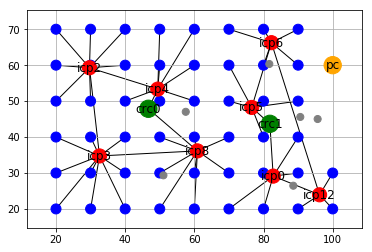

In [427]:
swap_list = swap_list_byRoute(best_solution["Y1"],W,DjUc,best_solution["N_icp"])

for iswap, swap in enumerate(swap_list)

routes_swap, N_icp_swap = swap_arcs(swap, best_solution["routes"], best_solution["N_icp"])
ney_Y = new_assignement(W,N_icp_swap)
draw_solution_II(I,J,C,N_crc, N_icp_swap,
        new_Y, np.zeros((3,8)), routes_swap.tolist(), expid,
        G, pos, labels, colors, size, path=expid+ "/"+ str(iswap) +"_swap.png")

# Run experiment

## Results

In [ ]:
objects = ('UFLP', 'CFLP', 'TUFLP', 'TCFLP')
y_pos = np.arange(len(objects))
performance = [result1.best,result2.best,result3.best,result4.best]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time s')
plt.title('Best processing time for each subproblem')
 
plt.show()